# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [1]:
import os
import requests
import re
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


## Introduction to Parsing Trees & Dataset

### Parsing Trees

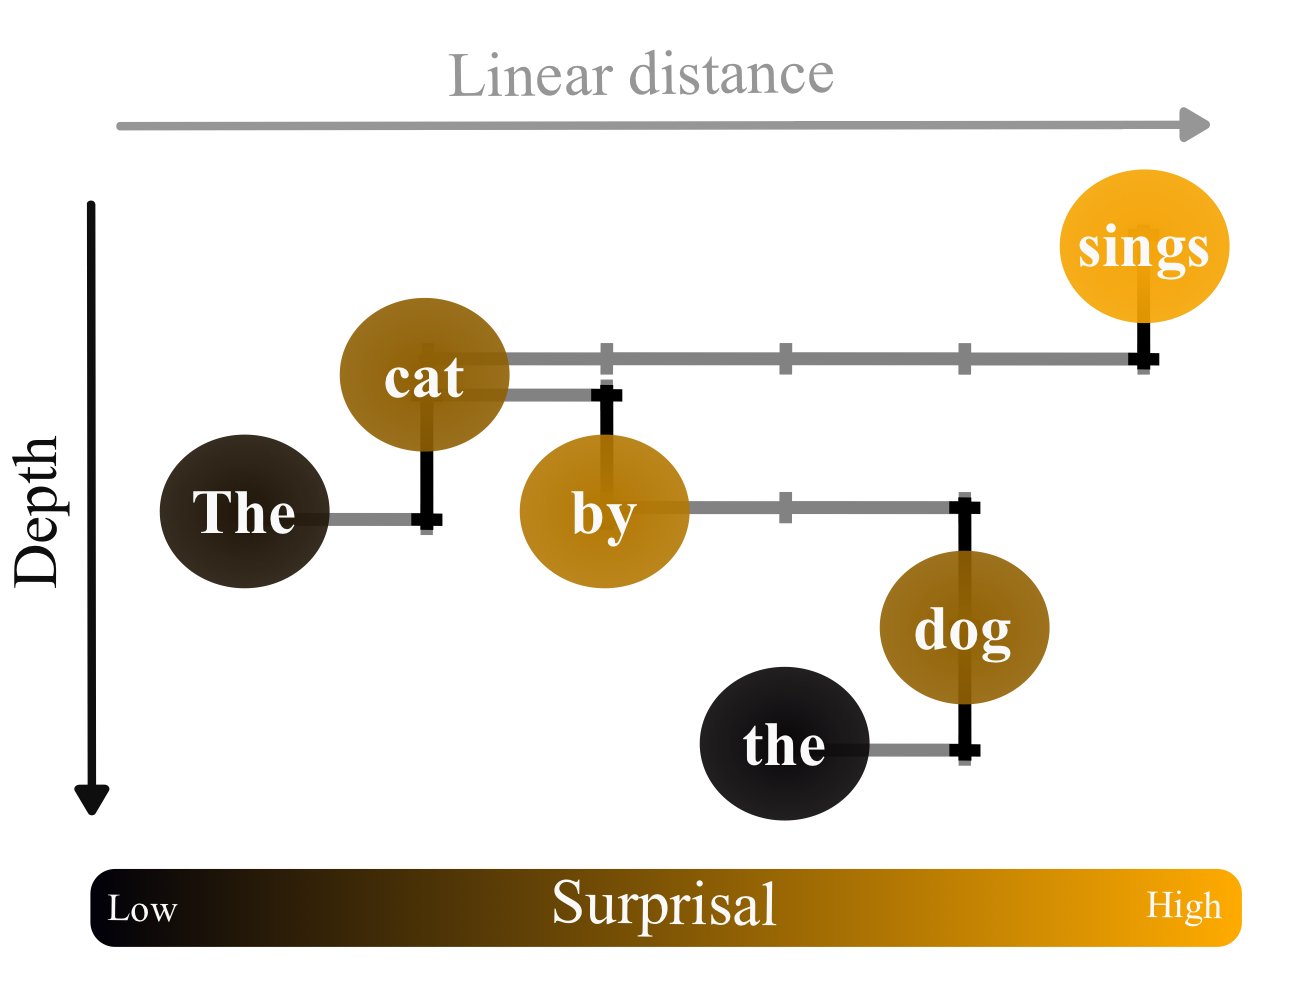

In [2]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adapted from Diego-Simon et al. (2025) depicts a typical **dependency-based parse** tree for a short sentence. Nodes in the tree represent words, and edges represent immediate dependencies. Nodes that connect to a lower-level node are referred to as that node’s **parent**, while the lower-level node is called the **child**. At the lowest depth, we find the **root** of the sentence (sings), which is the main verb of the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase “by the dog” modifies the subject “cat.”

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [3]:
def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

sentences_train, sentences_test = get_data()
print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12279 training sentences and 2004 test sentences.


Print some example sentences:

In [5]:
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentences_train[i].metadata["text"])

Use a well rinsed medicine vial, a cork, new fishing bobber or even a piece of non-crumbly styrofoam to float them.
There are many online sites offering the booking facility with affordable rates.
I thought it was dangerous for the baby so I moved him.
Problem is, for some reason, the visa process took longer than it should, thus I missed school this semester (visa was issued to me about 25 days after school started so I couldn't attend), now I no longer want to go into that school (because they only would accept me again on September of 2012), I found a school that accepted me for may 2012, can I use the same visa that was issued to me?
You review and approve it, keep it on your desk, and I will come over and make the change at your desk on Monday.


The dependency tree structure can be described by a single variable (head), specifying the **parent** of a given word.

In [6]:
idx = 59
print(sentences_test[idx].metadata["text"])
print("")
for tok in sentences_test[idx]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[idx][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

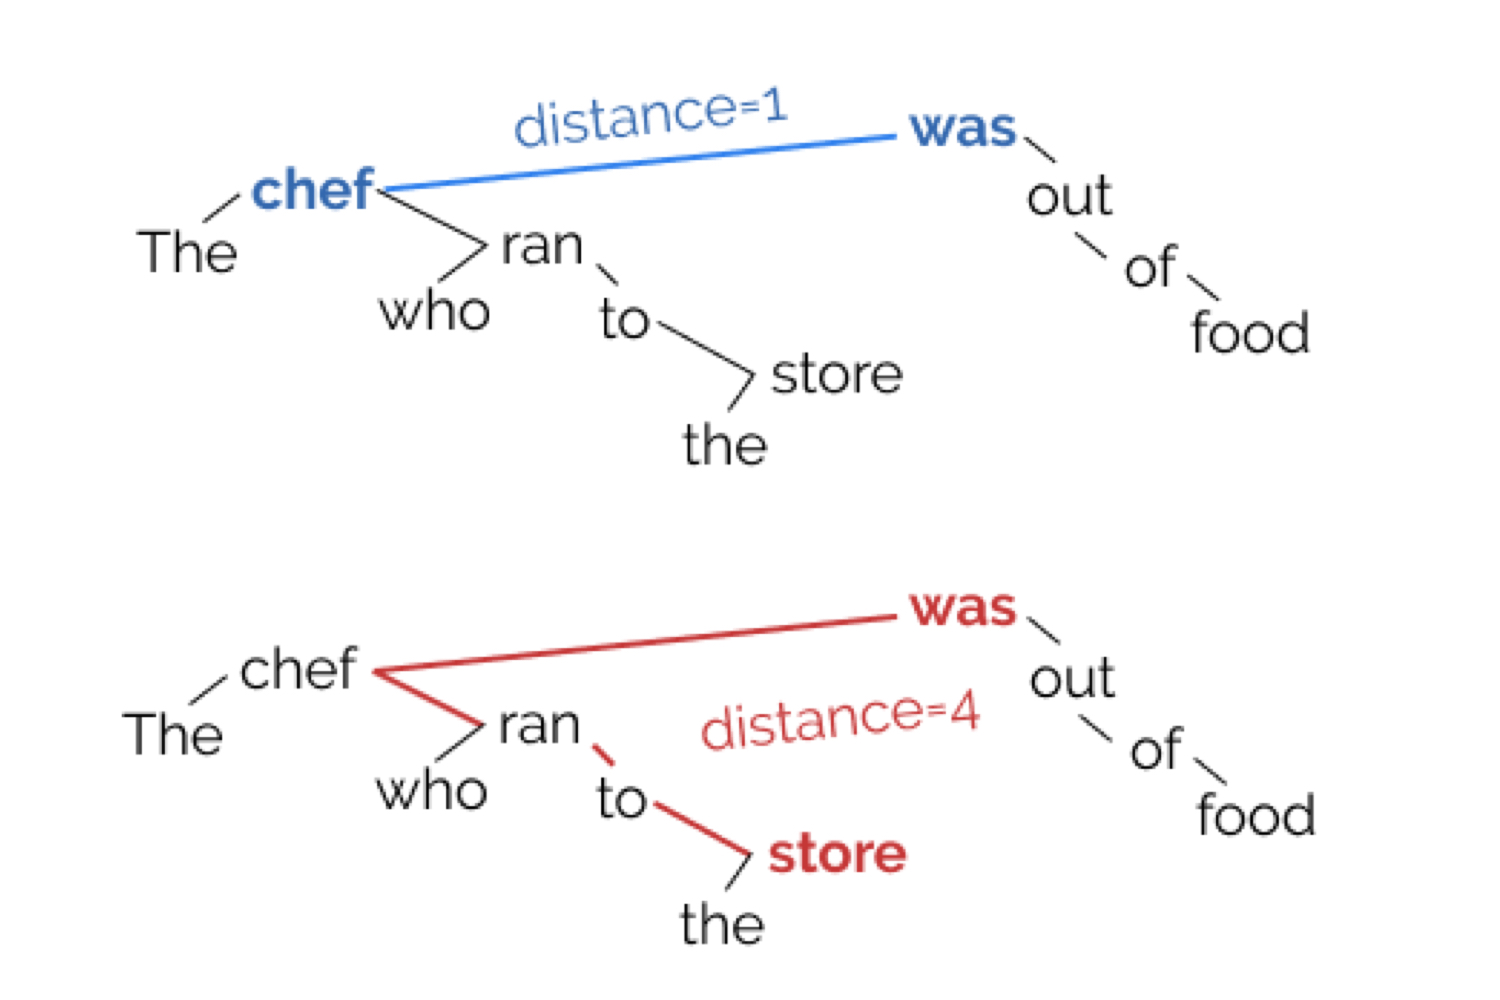

In [7]:
# example from Hewitt and Manning (2019)
image_path = "images/distance_scheme.jpeg"
display(Image(filename=image_path, width=400, height = 300))

## Methods ##

In a previous code block we imported the data from "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/", which is the Universal Dependencies dataset, as mentioned earlier. This dataset contains training and testing data; in addition, we take some of the training data as validation data later on.

### Define Functions

Below is a custom function to get syntactic tree distances from our annotated sentences

<Axes: >

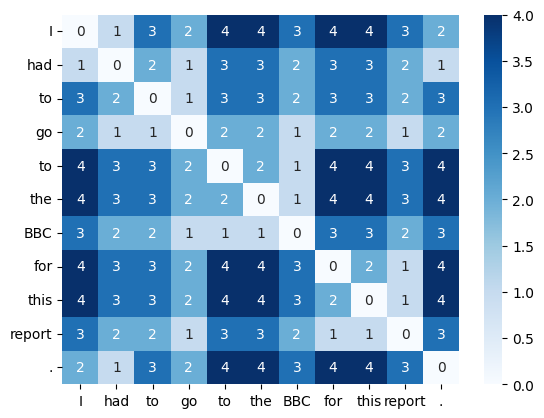

In [8]:
# expand to see function
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[idx])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transform the distance matrix into a dependency-based parse tree using the NetworkX library. We obtain the minimum spanning tree using Kruskal’s algorithm. Note that we manually set the node positions according to their order in the sentence (x-axis) and their distance from the root (i.e., depth; y-axis).

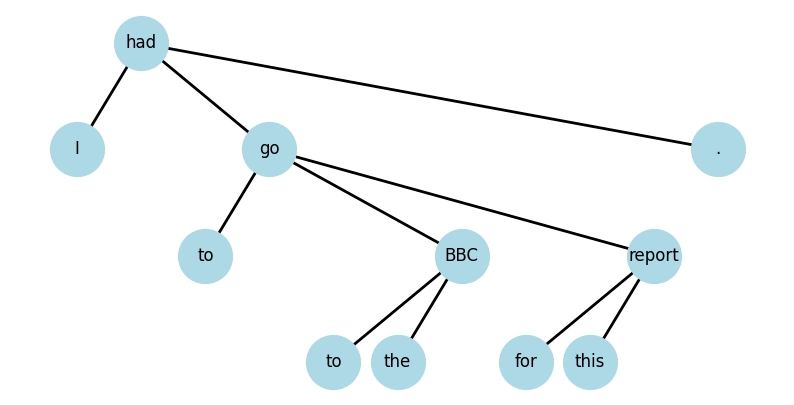

In [9]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2, plot = True):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix as np array
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist, to get a readable plot
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        nx.draw(
            mst,
            pos=pos,
            ax=ax,
            with_labels=True,
            labels={i: forms[i] for i in range(len(forms))},
            node_color='lightblue',
            edge_color='black',
            node_size=node_size,
            font_size=font_size,
            width=width,
        )
        ax.set_xlabel("ids")
        ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Let's do this for some more sentences:

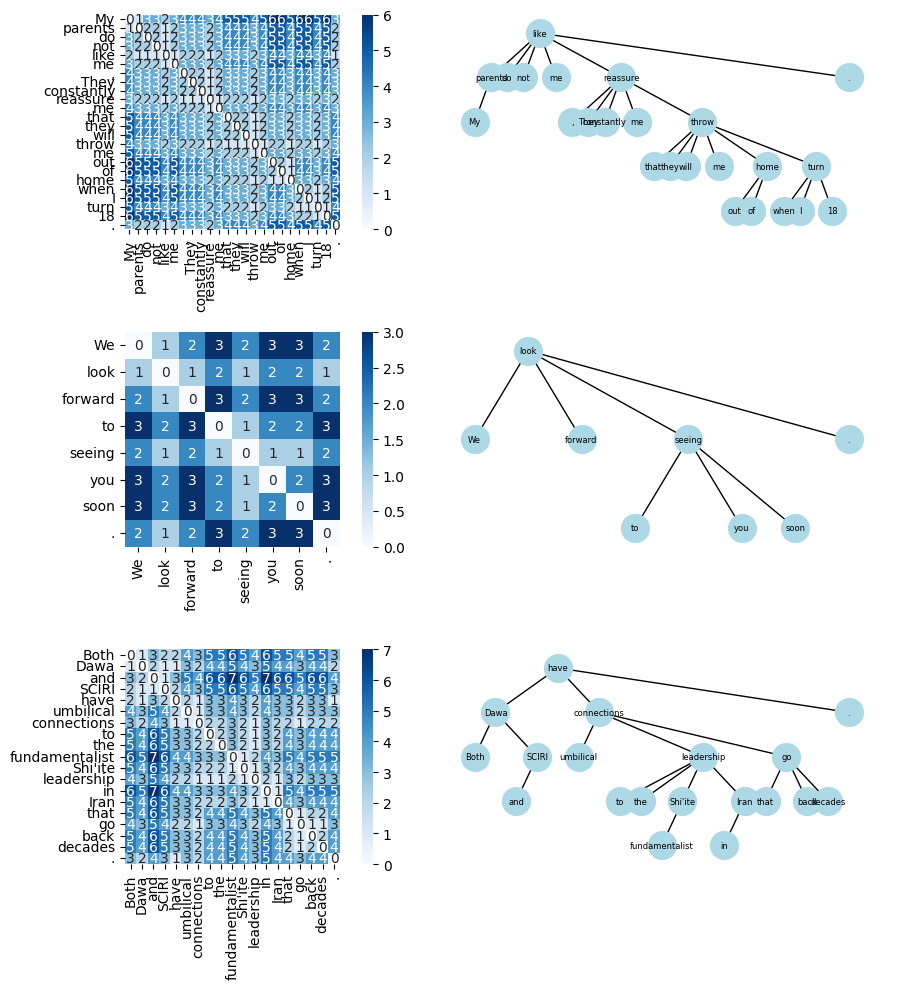

In [10]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(2) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

## Research Question

We evaluate whether parsing trees are embedded in the hidden layer of a large language model. However, se cannot decode the syntactic dependencies by looking at the raw embeddings, since these will also encode additional information, such as semantics or task relevant aspects for next-token prediction. Therefore, we will aim to extract the syntactic content using a **structural probe**, which maps the embeddings into a new, lower-dimensional structure (see figure below)

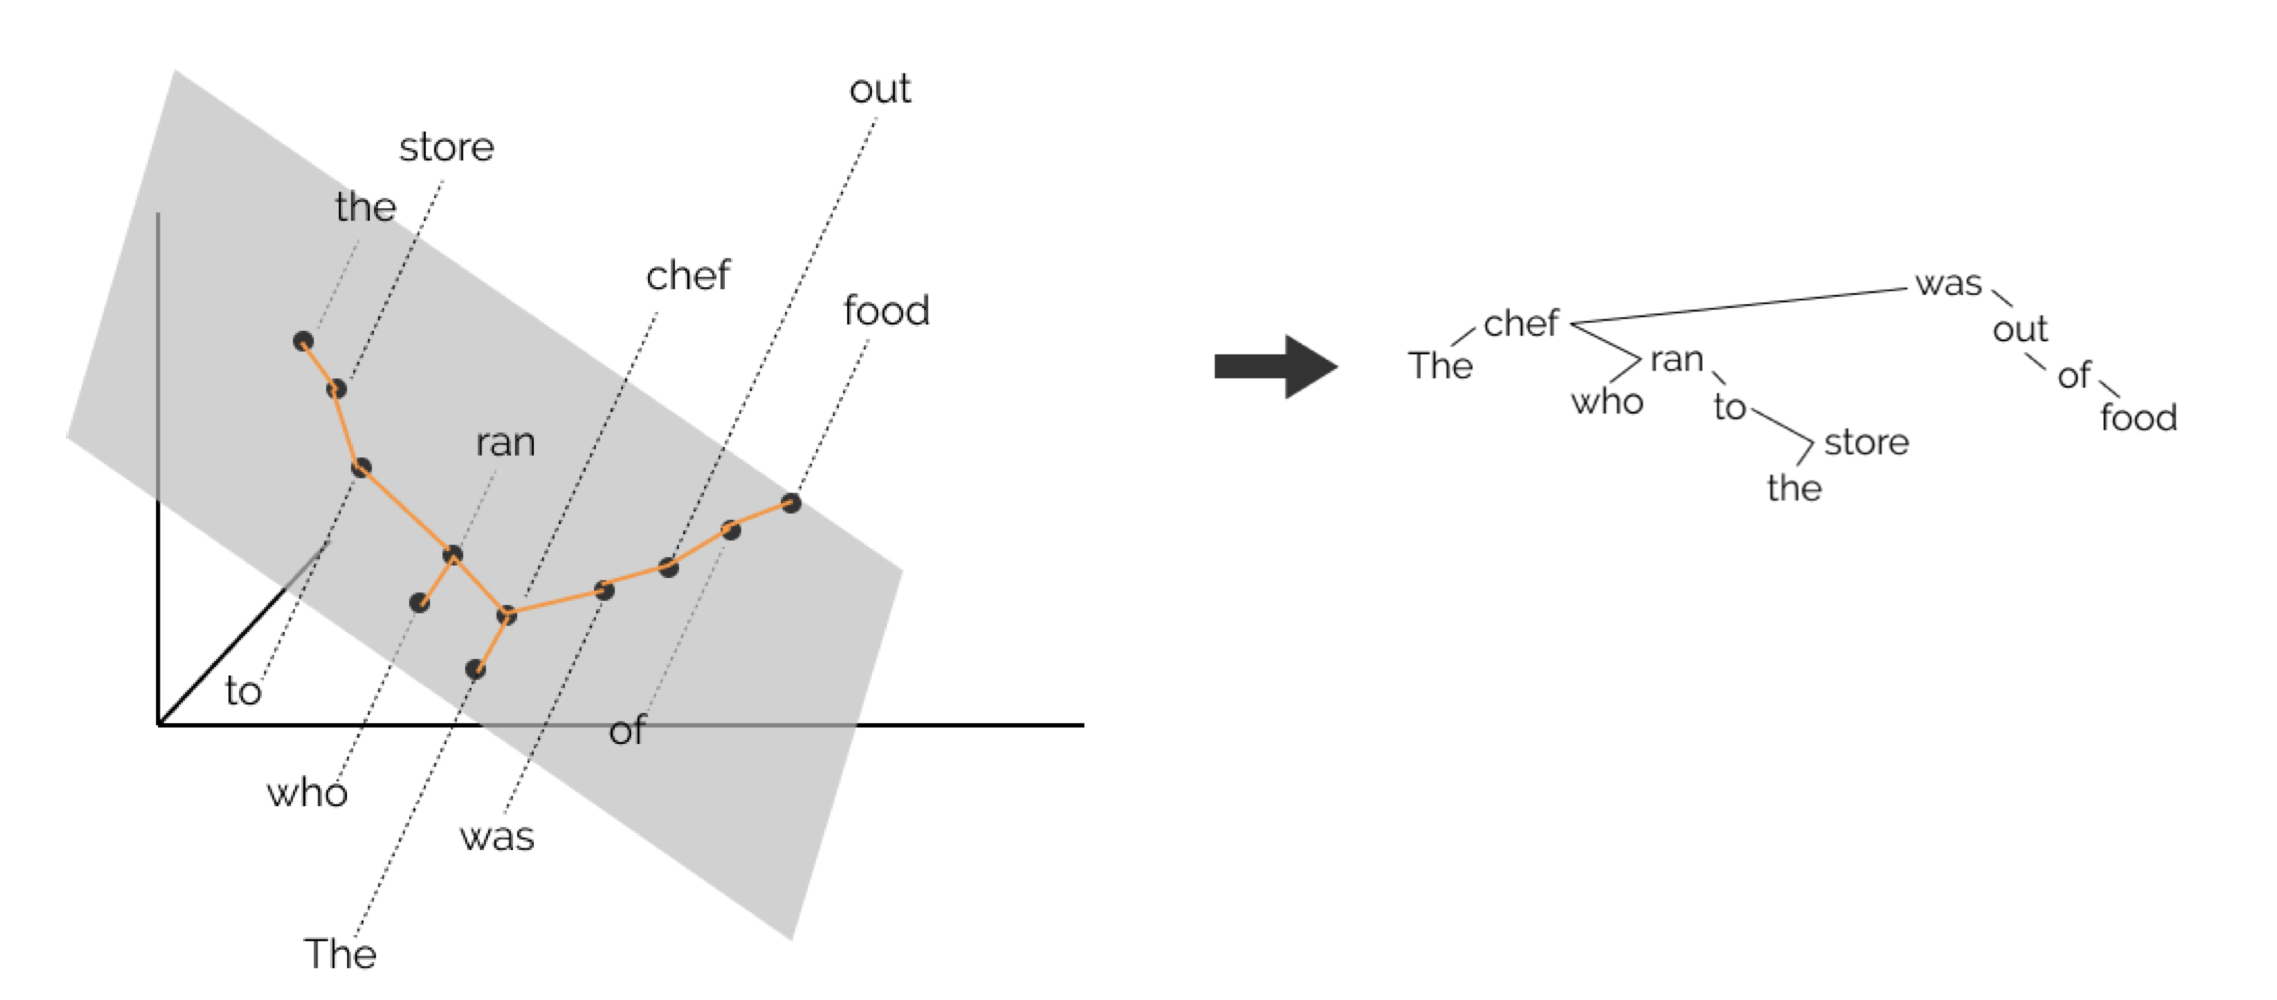

In [11]:
# from Hewitt and Manning (2019)
image_path = "images/probe_scheme.jpeg"
display(Image(filename=image_path, width=600, height=400))

The probe transforms the individual word embeddings (from the LLM) for each token in the sentence. Specifically, it projects each embedding into a lower-dimensional space (of a pre-determined size) using the learned probe matrix. Then, it computes pairwise distances between these projected embeddings to form the predicted syntactic distance matrix. Therefore, the only "deep" learning we do, is determining that projection matrices weights.

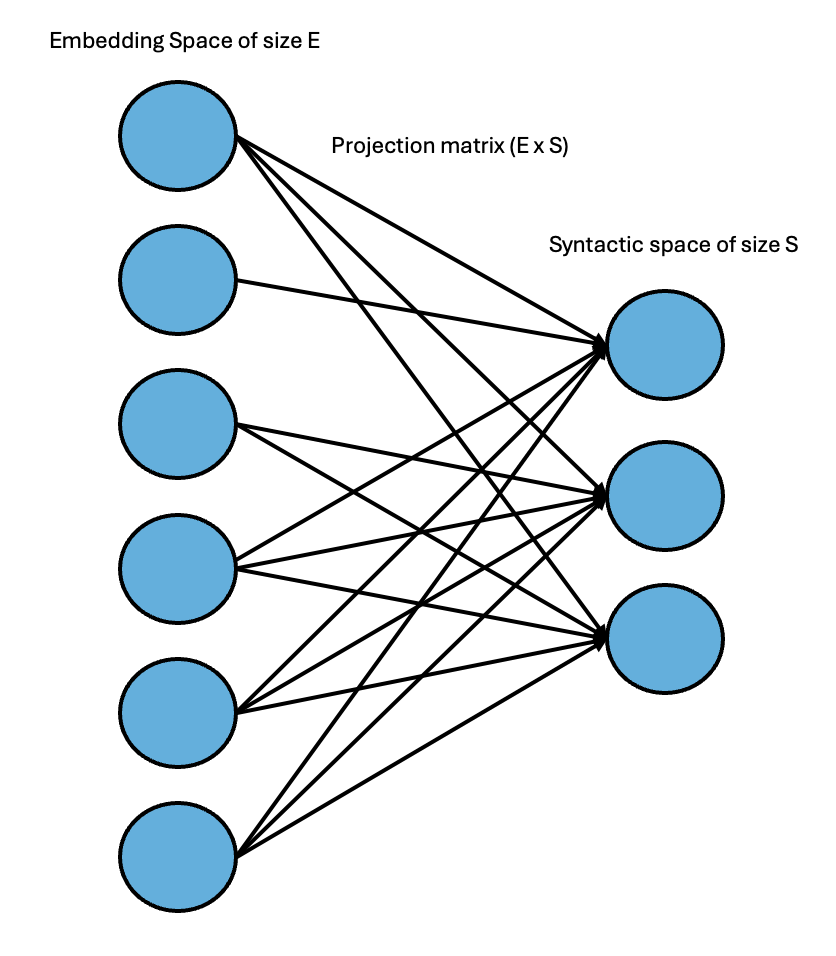

In [12]:
# add figure showing probe architecture
image_path = "images/mlp_scheme.png"
display(Image(filename=image_path, width=300, height=200))

## Implement Structural Probe

### Define functions to get embeddings and matrices

For the ground truth matrices, we just apply it to all our sentences in the for-loop. For the LLM-emeddings we need to ensure that the models tokenizer matches our annotations in the dataset. We do this by pooling the values of the embedding of the last sub-token. In other words, where the UD dataset often has 1 token for 1 word (e.g., unreliable), GPT2-small often has more (e.g., (1) un, (2) re, (3) liable). We take the (contextualized) embedding of the last sub-token to keep these embeddings most representative of the full word. Attempts with averaging across sub-tokens proved to be less effective than pooling from the last sub-token.

In [13]:
def get_matrices(sentences):
    """function to get distance matrices for a list of sentences"""
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices

In [14]:
def combine_token_embeddings(
    text,
    word_list,
    model,
    layer_name,
    pooling="last",
):
    tokenizer = model.tokenizer

    # --- Tokenize with HF for offsets ---
    encoding = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors="pt",
        add_special_tokens=False,
    )

    offsets = encoding["offset_mapping"][0].tolist()

    # --- Get activations from TransformerLens (NO BOS) ---
    _, cache = model.run_with_cache(
        [text],
        prepend_bos=False
    )
    activations = cache[layer_name][0]

    assert activations.shape[0] == len(offsets), (
        activations.shape[0],
        len(offsets),
    )

    # --- Find word spans ---
    word_spans = []
    cursor = 0

    for word in word_list:
        match = re.search(re.escape(word), text[cursor:])
        if match is None:
            raise ValueError(f"Word '{word}' not found after position {cursor}")

        start = cursor + match.start()
        end = start + len(word)
        word_spans.append((start, end))
        cursor = end

    # --- Pool token embeddings ---
    word_embeddings = []

    for (ws, we) in word_spans:
        token_idxs = [
            i for i, (ts, te) in enumerate(offsets)
            if ts < we and te > ws
        ]

        if not token_idxs:
            raise ValueError(
                f"No tokens aligned to '{text[ws:we]}' at span {(ws, we)}"
            )

        token_embs = activations[token_idxs]

        if pooling == "last":
            word_emb = token_embs[-1]
        elif pooling == "first":
            word_emb = token_embs[0]
        elif pooling == "mean":
            word_emb = token_embs.mean(dim=0)
        else:
            raise ValueError(f"Unknown pooling: {pooling}")

        word_embeddings.append(word_emb)

    return torch.stack(word_embeddings)

In [15]:
class SyntaxProbeDataset(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            activations = combine_token_embeddings(text, [tok["form"] for tok in sentence], model, layer_name)
            activation = activations.cpu().numpy()
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
                
            if activation.shape[0] > 0 and mat.shape[0] > 0:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]
    
def custom_collate_fn(batch):
    """Function to collate a batch of (activation, matrix) tuples by padding them to the same length."""
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None

### Load Data

In [16]:
mod = transformer_lens.HookedTransformer.from_pretrained("gpt2")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2 into HookedTransformer


In [17]:
sentences_train, sentences_test = get_data()

# create val split
np.random.seed(9)
val_idx = np.random.choice(len(sentences_train), size=int(0.1 * len(sentences_train)), replace=False)
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]

# exclude sentences with faulty annotations
faulty_indices = {}
for name, sentence_set in {"train": sentences_train, "val": sentences_val, "test": sentences_test}.items():
    skip_indices = []
    for i, sentence in tqdm(enumerate(sentence_set), desc=f"Checking {name} set"):
        try:
            _ = combine_token_embeddings(sentence.metadata['text'], 
                                        [tok['form'] for tok in sentence],
                                        mod,
                                        'blocks.8.hook_resid_post')
        except Exception as e:
            skip_indices.append(i)
    faulty_indices[name] = skip_indices
print(faulty_indices)
        


# len(sentences_train), len(sentences_val), len(sentences_test)

Checking train set: 0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Checking train set: 11052it [11:51, 15.54it/s]
Checking val set: 1227it [01:27, 14.07it/s]
Checking test set: 2004it [02:05, 16.01it/s]

{'train': [7, 28, 37, 43, 44, 46, 48, 55, 68, 82, 88, 100, 102, 107, 108, 110, 111, 117, 118, 120, 121, 133, 134, 135, 136, 137, 139, 141, 142, 143, 146, 147, 150, 153, 155, 156, 166, 178, 181, 187, 189, 191, 192, 198, 202, 203, 205, 210, 214, 215, 223, 227, 228, 229, 230, 231, 234, 240, 245, 247, 251, 254, 260, 275, 276, 277, 282, 283, 284, 285, 288, 311, 325, 326, 327, 328, 329, 330, 333, 342, 346, 348, 351, 365, 366, 367, 375, 390, 395, 398, 400, 401, 402, 403, 406, 407, 421, 426, 430, 434, 437, 438, 440, 445, 446, 447, 450, 456, 464, 465, 471, 479, 488, 495, 502, 510, 514, 516, 518, 525, 528, 530, 535, 540, 544, 546, 562, 564, 575, 583, 590, 592, 594, 595, 601, 602, 608, 611, 615, 616, 618, 623, 638, 644, 647, 655, 656, 657, 658, 660, 662, 666, 667, 668, 671, 673, 678, 680, 689, 690, 699, 700, 708, 709, 710, 717, 718, 720, 721, 722, 723, 729, 730, 733, 742, 748, 756, 757, 758, 759, 762, 764, 772, 782, 785, 786, 788, 789, 791, 792, 804, 808, 812, 815, 816, 817, 819, 823, 830, 837, 8

In [18]:
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in faulty_indices["train"]]
sentences_val = [sentences_val[i] for i in range(len(sentences_val)) if i not in faulty_indices["val"]]
sentences_test = [sentences_test[i] for i in range(len(sentences_test)) if i not in faulty_indices["test"]]
len(sentences_train), len(sentences_val), len(sentences_test)

(9039, 1029, 1703)

### Test Data

In [19]:
skip_counter = 0
for i in range(1000):
    sentx = sentences_test[i]
    print(sentx.metadata["text"])
    word_list = [tok["form"] for tok in sentx]
    print(word_list)
    print(sentx.metadata["text"])
    try:
        test = combine_token_embeddings(sentx.metadata["text"], 
                                        word_list,
                                        mod,
                                        "blocks.5.hook_mlp_out")
        print(test.shape)
    except Exception as e:
        skip_counter += 1
        continue

What if Google Morphed Into GoogleOS?
['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']
What if Google Morphed Into GoogleOS?
torch.Size([7, 768])
What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
['What', 'if', 'Google', 'expanded', 'on', 'its', 'search', '-', 'engine', '(', 'and', 'now', 'e-mail', ')', 'wares', 'into', 'a', 'full', '-', 'fledged', 'operating', 'system', '?']
What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
torch.Size([23, 768])
[via Microsoft Watch from Mary Jo Foley ]
['[', 'via', 'Microsoft', 'Watch', 'from', 'Mary', 'Jo', 'Foley', ']']
[via Microsoft Watch from Mary Jo Foley ]
torch.Size([9, 768])
(And, by the way, is anybody else just a little nostalgic for the days when that was a good thing?)
['(', 'And', ',', 'by', 'the', 'way', ',', 'is', 'anybody', 'else', 'just', 'a', 'little', 'nostalgic', 'for', 'the', 'days', 'when', 'that', 'was', 

### Implement Probes and Regimen

The code for the probes is adpated from https://github.com/john-hewitt/structural-probes

In [20]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

### Loss Function

We use a custom L1 regression loss on pairwise distance matrices. We calculate the mean absolute error (L1 loss) between predicted and true syntactic distance matrices. We normalize this per sentence and average over every batch.

In [21]:
class L1DistanceLoss(nn.Module):
  """Custom L1 loss for distance matrices."""
  def __init__(self, args):
    super(L1DistanceLoss, self).__init__()
    self.args = args
    self.word_pair_dims = (1,2)

  def forward(self, predictions, label_batch, length_batch):
    """ Computes L1 loss on distance matrices.

    Ignores all entries where label_batch=-1
    Normalizes first within sentences (by dividing by the square of the sentence length)
    and then across the batch.

    Args:
      predictions: A pytorch batch of predicted distances
      label_batch: A pytorch batch of true distances
      length_batch: A pytorch batch of sentence lengths

    Returns:
      A tuple of:
        batch_loss: average loss in the batch
        total_sents: number of sentences in the batch
    """
    device = predictions.device
    label_batch = label_batch.to(device)
    length_batch = length_batch.to(device)

    labels_1s = (label_batch != -1).float()
    predictions_masked = predictions * labels_1s
    labels_masked = label_batch * labels_1s
    total_sents = torch.sum((length_batch != 0)).float()
    squared_lengths = length_batch.pow(2).float()
    if total_sents > 0:
      loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=self.word_pair_dims)
      normalized_loss_per_sent = loss_per_sent / squared_lengths
      batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
    else:
      batch_loss = torch.tensor(0.0, device=self.args['device'])
    return batch_loss, total_sents


In [22]:
"""Classes for training and running inference on probes."""

class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

## Apply to layer

### Train Model

The following block sets up everything needed to train the probe on one specific layer, which can be specified separately. This includes configuration and data preparation. Our choice for gpt2-small was motivated by its size, allowing relatively easy use and smaller computation times. Additionally, gpt2-small is a early predecessor of modern GPT models, which means that this model may be (relatively) representative of the LLM's we work with nowadays, instead of a heavily outdated model-type. 

In [23]:
# this cell may take around 5-10 minutes to run, since all activations are being extracted and transformed to match data sequentially
# rank of probe and epoch was determined via validation set performance

layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 50},
    'reporting': {'root': './'}
}
probe = TwoWordPSDProbe(args)
loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 9039/9039 [11:18<00:00, 13.31it/s]


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1029/1029 [01:13<00:00, 14.08it/s]


Here we train the model.

In [24]:
# model training may also take about 10 minutes
regimen.train_until_convergence(
    probe=probe,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   2%|▏         | 1/50 [00:08<07:06,  8.70s/it]

[epoch 0] Train loss: 1417.1812089020495, Dev loss: 126.35415598996295
Saving probe parameters


[training]:   4%|▍         | 2/50 [00:16<06:20,  7.92s/it]

[epoch 1] Train loss: 80.52216512733018, Dev loss: 49.60548132478438
Saving probe parameters


[training]:   6%|▌         | 3/50 [00:23<05:52,  7.50s/it]

[epoch 2] Train loss: 32.99482851801806, Dev loss: 21.332109204765892
Saving probe parameters


[training]:   8%|▊         | 4/50 [00:29<05:23,  7.03s/it]

[epoch 3] Train loss: 14.233516952661514, Dev loss: 9.167947589366383
Saving probe parameters


[training]:  10%|█         | 5/50 [00:34<04:48,  6.42s/it]

[epoch 4] Train loss: 5.981941686107569, Dev loss: 3.707034605005856
Saving probe parameters


[training]:  12%|█▏        | 6/50 [00:39<04:22,  5.97s/it]

[epoch 5] Train loss: 2.5596154347261586, Dev loss: 1.8115195495857557
Saving probe parameters


[training]:  14%|█▍        | 7/50 [00:46<04:24,  6.16s/it]

[epoch 6] Train loss: 1.5693172605075407, Dev loss: 1.5102415492629635
Saving probe parameters


[training]:  16%|█▌        | 8/50 [00:52<04:17,  6.13s/it]

[epoch 7] Train loss: 1.3301239406156493, Dev loss: 1.0102856930768873
Saving probe parameters


[training]:  18%|█▊        | 9/50 [00:59<04:20,  6.35s/it]

[epoch 8] Train loss: 1.109412001803829, Dev loss: 0.897991490896983
Saving probe parameters


[training]:  20%|██        | 10/50 [01:04<04:02,  6.06s/it]

[epoch 9] Train loss: 1.0847477378511814, Dev loss: 0.8434133789166302
Saving probe parameters


[training]:  22%|██▏       | 11/50 [01:11<04:02,  6.22s/it]

[epoch 10] Train loss: 1.083958396527577, Dev loss: 0.845268539135843


[training]:  24%|██▍       | 12/50 [01:16<03:48,  6.00s/it]

[epoch 11] Train loss: 0.7259989869398068, Dev loss: 0.7867873301195566
Saving probe parameters


[training]:  26%|██▌       | 13/50 [01:22<03:36,  5.85s/it]

[epoch 12] Train loss: 0.7090235549879491, Dev loss: 0.7748281550245221
Saving probe parameters


[training]:  28%|██▊       | 14/50 [01:28<03:38,  6.06s/it]

[epoch 13] Train loss: 0.6985487850884287, Dev loss: 0.763198070553927
Saving probe parameters


[training]:  30%|███       | 15/50 [01:34<03:26,  5.91s/it]

[epoch 14] Train loss: 0.6935238377659415, Dev loss: 0.7499023707197985
Saving probe parameters


[training]:  32%|███▏      | 16/50 [01:40<03:24,  6.03s/it]

[epoch 15] Train loss: 0.6889280341792283, Dev loss: 0.7397034911998159
Saving probe parameters


[training]:  34%|███▍      | 17/50 [01:49<03:44,  6.80s/it]

[epoch 16] Train loss: 0.6832204309761662, Dev loss: 0.734191796290747
Saving probe parameters


[training]:  36%|███▌      | 18/50 [01:56<03:39,  6.85s/it]

[epoch 17] Train loss: 0.6773004255433014, Dev loss: 0.7340074669862975
Saving probe parameters


[training]:  38%|███▊      | 19/50 [02:01<03:13,  6.23s/it]

[epoch 18] Train loss: 0.6758948796775861, Dev loss: 0.7386334245939412


[training]:  40%|████      | 20/50 [02:05<02:54,  5.82s/it]

[epoch 19] Train loss: 0.6523634664436557, Dev loss: 0.7143568290565869
Saving probe parameters


[training]:  42%|████▏     | 21/50 [02:10<02:41,  5.58s/it]

[epoch 20] Train loss: 0.6481620560890938, Dev loss: 0.7120959068294632
Saving probe parameters


[training]:  44%|████▍     | 22/50 [02:15<02:30,  5.37s/it]

[epoch 21] Train loss: 0.646500962117378, Dev loss: 0.710607125993141
Saving probe parameters


[training]:  46%|████▌     | 23/50 [02:20<02:19,  5.18s/it]

[epoch 22] Train loss: 0.6453976148471775, Dev loss: 0.7092531865030035
Saving probe parameters


[training]:  48%|████▊     | 24/50 [02:25<02:11,  5.07s/it]

[epoch 23] Train loss: 0.6442161712621163, Dev loss: 0.7092026204478984


[training]:  50%|█████     | 25/50 [02:29<02:03,  4.94s/it]

[epoch 24] Train loss: 0.6398271361683464, Dev loss: 0.7072011333165293
Saving probe parameters


[training]:  52%|█████▏    | 26/50 [02:34<01:58,  4.92s/it]

[epoch 25] Train loss: 0.6389787834109241, Dev loss: 0.7069932429737206
Saving probe parameters


[training]:  54%|█████▍    | 27/50 [02:39<01:53,  4.92s/it]

[epoch 26] Train loss: 0.6386563603573898, Dev loss: 0.7067984783962239
Saving probe parameters


[training]:  56%|█████▌    | 28/50 [02:44<01:46,  4.86s/it]

[epoch 27] Train loss: 0.6383616917691725, Dev loss: 0.7065294046096134
Saving probe parameters


[training]:  58%|█████▊    | 29/50 [02:49<01:42,  4.87s/it]

[epoch 28] Train loss: 0.6380370008508931, Dev loss: 0.7063065047861883
Saving probe parameters


[training]:  60%|██████    | 30/50 [02:54<01:36,  4.84s/it]

[epoch 29] Train loss: 0.6377353877115993, Dev loss: 0.7060997493065481
Saving probe parameters


[training]:  62%|██████▏   | 31/50 [02:59<01:32,  4.85s/it]

[epoch 30] Train loss: 0.6374138828821581, Dev loss: 0.7057830803132498
Saving probe parameters


[training]:  64%|██████▍   | 32/50 [03:03<01:27,  4.84s/it]

[epoch 31] Train loss: 0.6371147229827364, Dev loss: 0.7055137155123192
Saving probe parameters


[training]:  66%|██████▌   | 33/50 [03:08<01:22,  4.86s/it]

[epoch 32] Train loss: 0.6367099221557996, Dev loss: 0.7052366902691514
Saving probe parameters


[training]:  68%|██████▊   | 34/50 [03:13<01:18,  4.89s/it]

[epoch 33] Train loss: 0.6364590914616847, Dev loss: 0.7049225041655456
Saving probe parameters


[training]:  70%|███████   | 35/50 [03:18<01:12,  4.83s/it]

[epoch 34] Train loss: 0.636003396141541, Dev loss: 0.7045385205015844
Saving probe parameters


[training]:  72%|███████▏  | 36/50 [03:23<01:07,  4.84s/it]

[epoch 35] Train loss: 0.635579649807803, Dev loss: 0.7042471855096845
Saving probe parameters


[training]:  74%|███████▍  | 37/50 [03:28<01:02,  4.82s/it]

[epoch 36] Train loss: 0.6352428990611065, Dev loss: 0.7038806191454592
Saving probe parameters


[training]:  76%|███████▌  | 38/50 [03:32<00:58,  4.83s/it]

[epoch 37] Train loss: 0.634745582224376, Dev loss: 0.7034204805557651
Saving probe parameters


[training]:  78%|███████▊  | 39/50 [03:37<00:53,  4.85s/it]

[epoch 38] Train loss: 0.634230593873252, Dev loss: 0.7030228507298654
Saving probe parameters


[training]:  80%|████████  | 40/50 [03:42<00:48,  4.87s/it]

[epoch 39] Train loss: 0.6337387647522222, Dev loss: 0.7025672678117966
Saving probe parameters


[training]:  82%|████████▏ | 41/50 [03:47<00:43,  4.89s/it]

[epoch 40] Train loss: 0.6331599770769739, Dev loss: 0.7021984442329963
Saving probe parameters


[training]:  84%|████████▍ | 42/50 [03:52<00:38,  4.83s/it]

[epoch 41] Train loss: 0.6326531141069903, Dev loss: 0.7016863790499109
Saving probe parameters


[training]:  86%|████████▌ | 43/50 [03:58<00:36,  5.22s/it]

[epoch 42] Train loss: 0.6321619154935073, Dev loss: 0.7012046298665602
Saving probe parameters


[training]:  88%|████████▊ | 44/50 [04:03<00:31,  5.21s/it]

[epoch 43] Train loss: 0.6316707576055788, Dev loss: 0.7006076603287974
Saving probe parameters


[training]:  90%|█████████ | 45/50 [04:08<00:25,  5.07s/it]

[epoch 44] Train loss: 0.6310575546212317, Dev loss: 0.7001554639276888
Saving probe parameters


[training]:  92%|█████████▏| 46/50 [04:13<00:19,  5.00s/it]

[epoch 45] Train loss: 0.6305303248648017, Dev loss: 0.6995908588431667
Saving probe parameters


[training]:  94%|█████████▍| 47/50 [04:17<00:14,  4.90s/it]

[epoch 46] Train loss: 0.6300214898706287, Dev loss: 0.6992957478477841
Saving probe parameters


[training]:  96%|█████████▌| 48/50 [04:22<00:09,  4.88s/it]

[epoch 47] Train loss: 0.629484438503167, Dev loss: 0.6986805129908495
Saving probe parameters


[training]:  98%|█████████▊| 49/50 [04:27<00:04,  4.81s/it]

[epoch 48] Train loss: 0.628956653887435, Dev loss: 0.6984858897499255
Saving probe parameters


[training]: 100%|██████████| 50/50 [04:32<00:00,  5.44s/it]

[epoch 49] Train loss: 0.6284745685135531, Dev loss: 0.6979692332135229
Saving probe parameters


### Loading a probe dict

In [25]:
matrix = torch.load('probe_params/blocks.8.hook_resid_post_probe_params.pt')

In [26]:
matrix['proj'].shape

torch.Size([768, 64])

In [27]:
# Set up args as in training
layer = 'blocks.8.hook_resid_post'
args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
# Load probe and parameters
probe_test = TwoWordPSDProbe(args)
state_dict = torch.load(args['probe']['params_path'], map_location=args['device'])
probe_test.load_state_dict(state_dict)
probe_test.eval()

Constructing TwoWordPSDProbe


TwoWordPSDProbe()

In [28]:
# Prepare your evaluation dataset and dataloader
novel_sentences = sentences_test  # or any list of sentences
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size=100, collate_fn=custom_collate_fn)

class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

# Use regimen's predict method
predictions = regimen.predict(probe_test, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 18/18 [00:00<00:00, 25.88it/s]


## Model Evaluation

First, we take a look at the loss curves. Loss is decreasing over epochs which means that at least something is being learned successfully. Moreover, there os no evidence of overfitting.

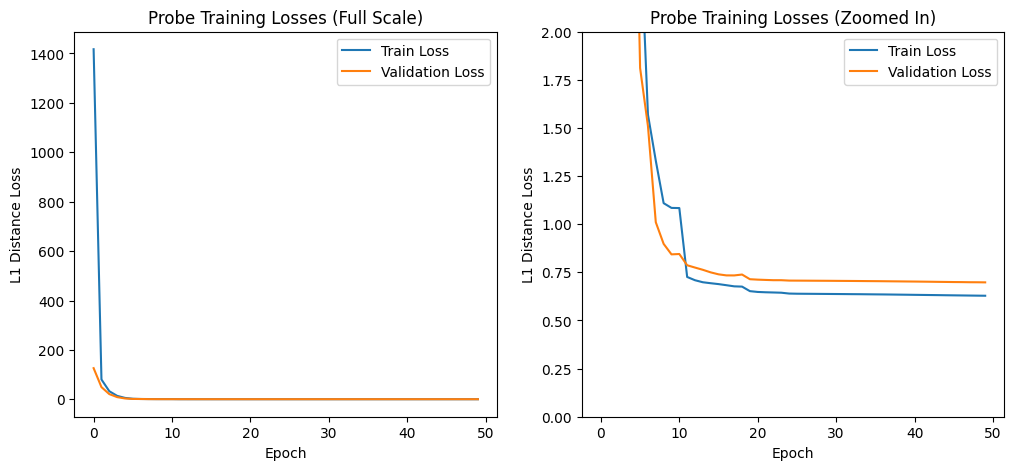

In [29]:
# loss function plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(regimen.train_losses, label='Train Loss')
ax[0].plot(regimen.val_losses, label='Validation Loss')
ax[0].set_title('Probe Training Losses (Full Scale)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('L1 Distance Loss')
ax[0].legend()

ax[1].plot(regimen.train_losses, label='Train Loss')
ax[1].plot(regimen.val_losses, label='Validation Loss')
ax[1].set_title('Probe Training Losses (Zoomed In)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('L1 Distance Loss')
ax[1].set_ylim(0, 2)
ax[1].legend()

Loss curves are nice, but not very interpretable. So next we apply our model on some previously unseen sentences (the test set)

In [30]:
# Prepare new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = sentences_test
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 18/18 [00:00<00:00, 35.41it/s]


we can go somewhere nice.


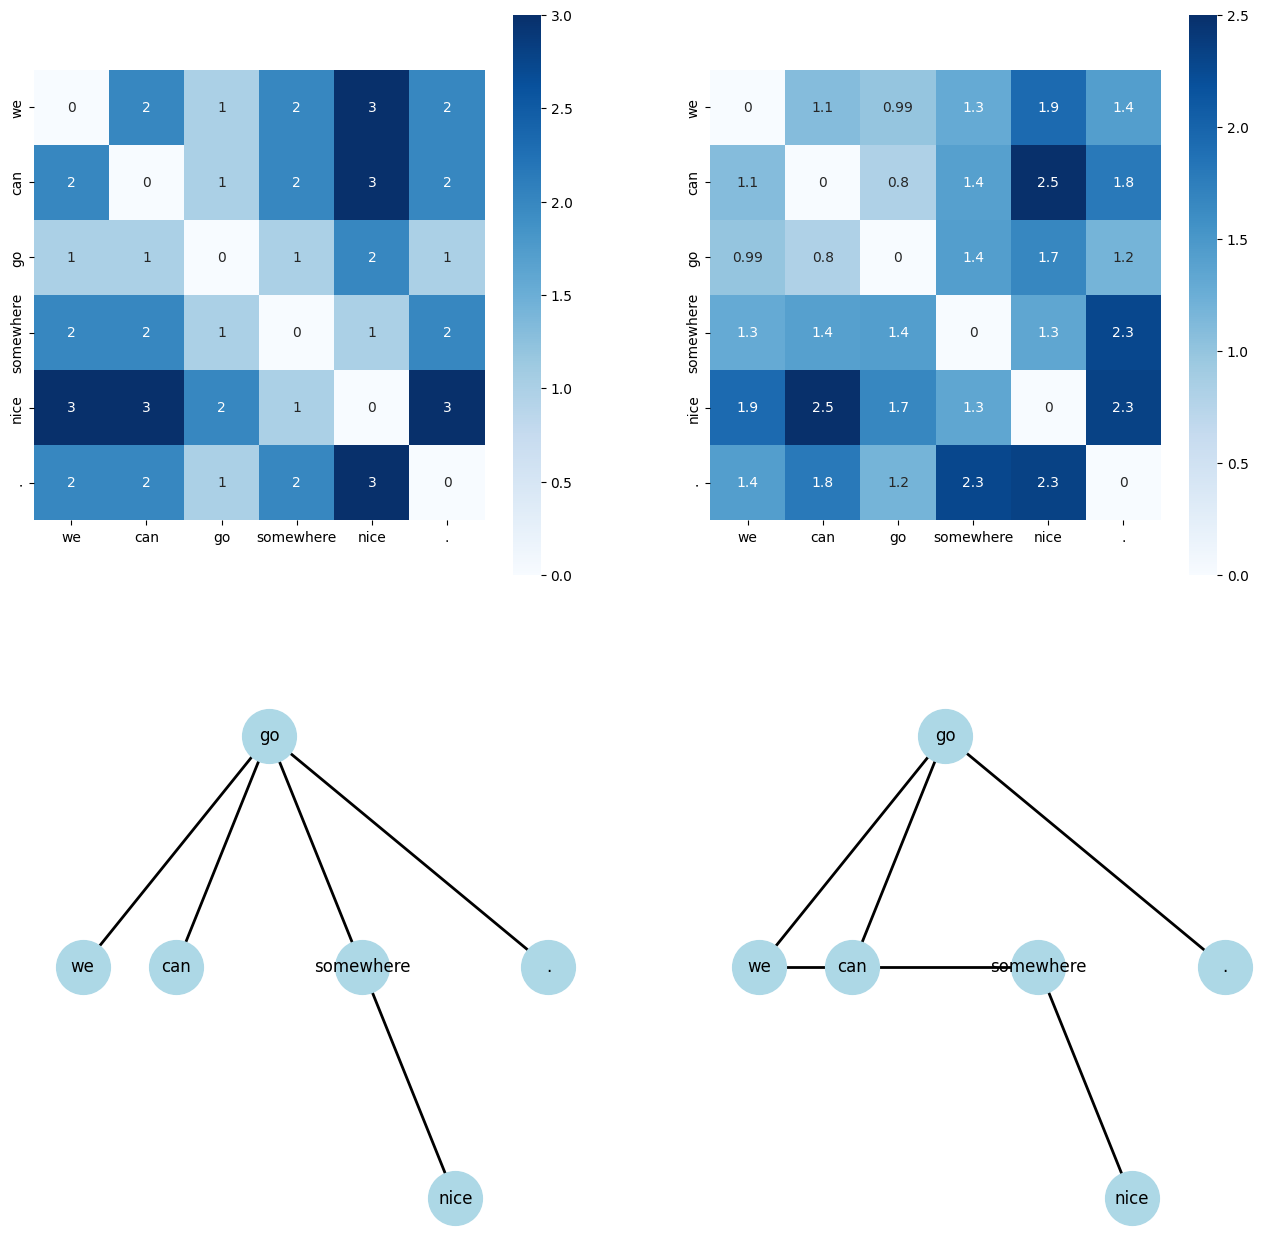

In [31]:
# plot an example of true vs. predicted sentence
sentence_idx = 188
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
# true mat
sns.heatmap(mat, cmap = "Blues", square = True, annot = True, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])

graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0])
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1])

plt.show()

In [32]:
from scipy.stats import spearmanr
def eval_parse_trees_by_sentence(test_sentences, predictions, batch_size):
    df = pd.DataFrame(columns=['sentence_length', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'sensitivity', 'specificity', 'spearman_rho'])
    for sentence_idx, sentence in enumerate(test_sentences):
        
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]
        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices_from(m1, k=1)
        upper_m1 = m1[inds]
        upper_m2 = m2[inds]

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))
    
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # aka recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 

        inds = np.triu_indices_from(mat, k=1)
        upper_mat = mat[inds]
        upper_pred_mat = pred_mat[inds]

        rho, _ = spearmanr(upper_mat, upper_pred_mat)

        df.loc[sentence_idx] = [n,TP, TN, FP, FN, accuracy, sensitivity, specificity, rho]

    return df

In [33]:
eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=predictions, batch_size=100).mean()

sentence_length    11.005285
TP                  5.617733
TN                 88.755725
FP                  4.387551
FN                  4.387551
accuracy            0.766975
sensitivity         0.583639
specificity         0.713182
spearman_rho        0.556355
dtype: float64

In [34]:
def eval_parse_trees_by_depth(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0

    df = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices(n, k=1)
        for i, j in zip(inds[0], inds[1]):
            lin_dist = abs(i - j) if abs(i - j) < 10 else 10 # bin all values >= 10 together
            if lin_dist not in df.index:
                df.loc[lin_dist] = [0, 0, 0, 0]

            gold_edge = (m1[i, j] != 0)
            pred_edge = (m2[i, j] != 0)

            if gold_edge and pred_edge:
                total_TP += 1
                df.at[lin_dist, 'TP'] += 1
            elif (not gold_edge) and (not pred_edge):
                total_TN += 1
                df.at[lin_dist, 'TN'] += 1
            elif (not gold_edge) and pred_edge:
                total_FP += 1
                df.at[lin_dist, 'FP'] += 1
            elif gold_edge and (not pred_edge):
                total_FN += 1
                df.at[lin_dist, 'FN'] += 1

    # safe per-distance metrics
    df['accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
    df['sensitivity'] = np.where((df['TP'] + df['FN']) > 0, df['TP'] / (df['TP'] + df['FN']), 0)
    df['specificity'] = np.where((df['TN'] + df['FP']) > 0, df['TN'] / (df['TN'] + df['FP']), 0)
    df = df.fillna(0).sort_index()
    return df
            
# eval_df = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

In [35]:
eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

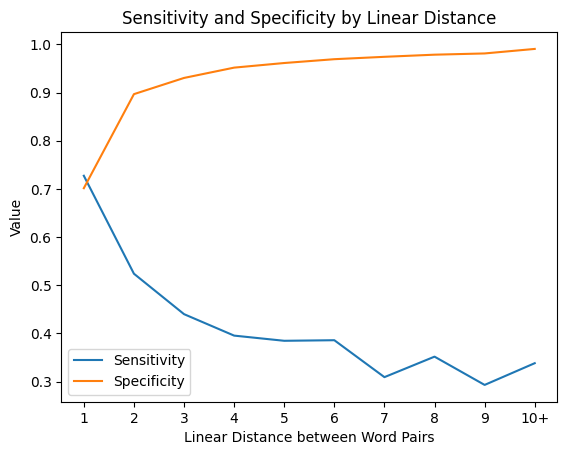

In [36]:
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["sensitivity"])
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["specificity"])
plt.xticks(np.arange(len(eval_df_depth)), labels= [str(i) for i in eval_df_depth.index][:len(eval_df_depth) - 1] + ["10+"])
plt.xlabel("Linear Distance between Word Pairs")
plt.ylabel("Value")
plt.title("Sensitivity and Specificity by Linear Distance")
plt.legend(["Sensitivity", "Specificity"])
plt.show()

In [37]:
eval_df_sentence = eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=predictions, batch_size=100)
eval_df_sentence

,sentence_length,TP,TN,FP,FN,accuracy,sensitivity,specificity,spearman_rho
0,7.0,3.0,12.0,3.0,3.0,0.714286,0.500000,0.800000,0.043533
1,23.0,9.0,218.0,13.0,13.0,0.897233,0.409091,0.943723,0.635695
2,9.0,3.0,23.0,5.0,5.0,0.722222,0.375000,0.821429,0.307226
3,25.0,7.0,259.0,17.0,17.0,0.886667,0.291667,0.938406,0.595393
4,7.0,2.0,11.0,4.0,4.0,0.619048,0.333333,0.733333,0.087039
...,...,...,...,...,...,...,...,...,...
1698,2.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,NaN
1699,3.0,2.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.866025
1700,10.0,6.0,33.0,3.0,3.0,0.866667,0.666667,0.916667,0.756865
1701,26.0,17.0,292.0,8.0,8.0,0.950769,0.680000,0.973333,0.714764


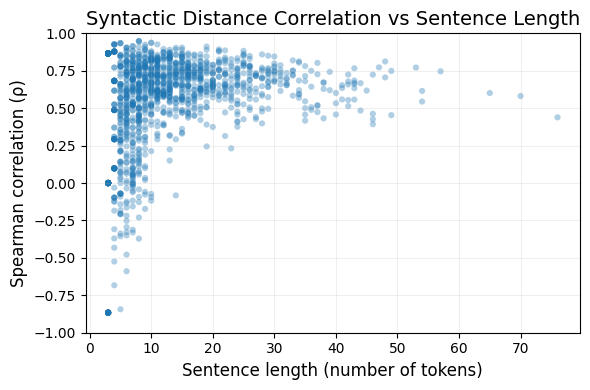

In [45]:
plt.figure(figsize=(6, 4))

plt.scatter(
    eval_df_sentence['sentence_length'],
    eval_df_sentence['spearman_rho'],
    s=20,
    alpha=0.35,
    edgecolors='none'
)

plt.xlabel("Sentence length (number of tokens)", fontsize=12)
plt.ylabel("Spearman correlation (ρ)", fontsize=12)
plt.title("Syntactic Distance Correlation vs Sentence Length", fontsize=14)

plt.ylim(-1.0, 1.0)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [46]:
# generate linear baseline
def create_linear_baseline(test_sentences):
    baseline_matrices = []
    for sentence_idx, sentence in enumerate(test_sentences):

        mat, _, _, _ = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        baseline_mat = np.zeros((n, n), dtype=int)
        for i in range(n):
            for j in range(n):
                baseline_mat[i, j] = abs(i - j)
        baseline_matrices.append(baseline_mat)
    return baseline_matrices

In [47]:
dummies = [[mat] for mat in create_linear_baseline(novel_sentences)]
dummy_df = eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=dummies, batch_size=1)


In [48]:
print(dummy_df.mean())
print("----")
print(eval_df_sentence.mean())

sentence_length    11.005285
TP                  4.140341
TN                 87.278332
FP                  5.864944
FN                  5.864944
accuracy            0.731631
sensitivity         0.476520
specificity         0.696079
spearman_rho        0.357577
dtype: float64
----
sentence_length    11.005285
TP                  5.617733
TN                 88.755725
FP                  4.387551
FN                  4.387551
accuracy            0.766975
sensitivity         0.583639
specificity         0.713182
spearman_rho        0.556355
dtype: float64


In [49]:
df1 = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=dummies, batch_size=1)
eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

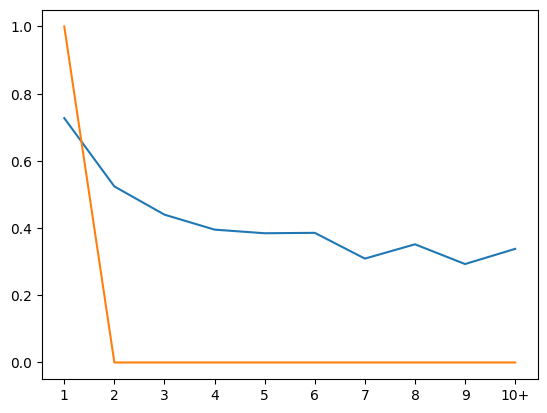

In [50]:
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["sensitivity"])
plt.plot(np.arange(len(df1)), df1["sensitivity"])
plt.xticks(np.arange(len(eval_df_depth)), labels= [str(i) for i in eval_df_depth.index][:len(eval_df_depth) - 1] + ["10+"])
plt.show()

## Scale up to multiple layers

In [51]:
df_acc = pd.read_pickle('df_acc.pkl')
layer_names = [
    'hook_embed',
    'blocks.0.hook_resid_pre',
    'blocks.0.hook_resid_post', 
    'blocks.2.hook_resid_post', 
    'blocks.4.hook_resid_post',
    'blocks.6.hook_resid_post',
    'blocks.10.hook_resid_post',
    'blocks.11.hook_resid_post'
    ]
for layer_name in layer_names:
    if layer_name in df_acc['layer_name'].values:
        print("skipping layer:", layer_name, " already processed")
        continue
    print(f"Processing layer: {layer_name}")
        
    args = {
        'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer_name}_probe_params.pt'},
        'model': {'hidden_dim': 768},
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'probe_training': {'epochs': 50},
        'reporting': {'root': './'}
    }
    probe = TwoWordPSDProbe(args)
    loss_fn = L1DistanceLoss(args)
    regimen = ProbeRegimen(args)

    dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer_name)
    dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

    val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer_name)
    val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

    # we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
    class IdentityModel(nn.Module):
        def forward(self, x):
            return x
    model = IdentityModel()

    regimen.train_until_convergence(
        probe=probe,
        model=model,
        loss=loss_fn,
        train_dataset=dataloader,
        dev_dataset=val_dataloader
    )
    
    # Make predictions
    # Prepare new sentences as a SyntaxProbeDataset and DataLoader
    novel_sentences = sentences_test
    novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer_name)
    novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

    # Make predictions
    predictions = regimen.predict(probe, model, novel_dataloader)

    eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)
    eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
    df_acc.loc[len(df_acc)] = [layer_name, regimen.train_losses, regimen.val_losses, eval_df_depth, eval_df_sentence]
    pd.to_pickle(df_acc, f'df_acc.pkl')


skipping layer: hook_embed  already processed
skipping layer: blocks.0.hook_resid_pre  already processed
skipping layer: blocks.0.hook_resid_post  already processed
skipping layer: blocks.2.hook_resid_post  already processed
skipping layer: blocks.4.hook_resid_post  already processed
skipping layer: blocks.6.hook_resid_post  already processed
skipping layer: blocks.10.hook_resid_post  already processed
skipping layer: blocks.11.hook_resid_post  already processed


In [52]:
eval_df_sentence.mean()

sentence_length    11.005285
TP                  5.617733
TN                 88.755725
FP                  4.387551
FN                  4.387551
accuracy            0.766975
sensitivity         0.583639
specificity         0.713182
spearman_rho        0.556355
dtype: float64

## MLP Probe

In [53]:
class MultiLayerProbe(Probe):
    """A multilayer probe using a small MLP."""
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.model_dim = args['model']['hidden_dim']
        self.probe_rank = args['probe']['maximum_rank']
        self.hidden_dim = args['probe'].get('mlp_hidden_dim', 256)
        self.device = args['device']

        self.mlp = nn.Sequential(
            nn.Linear(self.model_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.probe_rank)    
        )
        self.to(self.device)

    def forward(self, batch):
        batch = batch.to(self.device)
        transformed = self.mlp(batch)
        batchlen, seqlen, rank = transformed.size()
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1, 2)
        diffs = transformed - transposed
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)
        return squared_distances

In [54]:
layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 
              'mlp_hidden_dim': 256,
              'params_path': f'probe_params/multilayer_{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 50},
    'reporting': {'root': './'}
}
probe_multilayer = MultiLayerProbe(args) ######

loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 9039/9039 [09:36<00:00, 15.67it/s]


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1029/1029 [01:13<00:00, 13.93it/s]


In [55]:
regimen.train_until_convergence(
    probe=probe_multilayer,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   2%|▏         | 1/50 [00:10<08:24, 10.29s/it]

[epoch 0] Train loss: 49.888223836928134, Dev loss: 1.0851322068417386
Saving probe parameters


[training]:   4%|▍         | 2/50 [00:14<05:33,  6.94s/it]

[epoch 1] Train loss: 0.8905500522136214, Dev loss: 0.8907074515858938
Saving probe parameters


[training]:   6%|▌         | 3/50 [00:19<04:44,  6.05s/it]

[epoch 2] Train loss: 0.8570016606057926, Dev loss: 0.8167425749716652
Saving probe parameters


[training]:   8%|▊         | 4/50 [00:24<04:15,  5.56s/it]

[epoch 3] Train loss: 0.8583940908383685, Dev loss: 0.757696888073772
Saving probe parameters


[training]:  10%|█         | 5/50 [00:30<04:20,  5.78s/it]

[epoch 4] Train loss: 0.8699132257996044, Dev loss: 0.7325216041709521
Saving probe parameters


[training]:  12%|█▏        | 6/50 [00:37<04:23,  6.00s/it]

[epoch 5] Train loss: 1.0623761389236797, Dev loss: 0.7283805827705228
Saving probe parameters


[training]:  14%|█▍        | 7/50 [00:42<04:01,  5.63s/it]

[epoch 6] Train loss: 1.0078894009248835, Dev loss: 0.8194358138000073


[training]:  16%|█▌        | 8/50 [00:47<03:53,  5.57s/it]

[epoch 7] Train loss: 0.6102842414704872, Dev loss: 0.6654992344543932
Saving probe parameters


[training]:  18%|█▊        | 9/50 [00:53<03:46,  5.53s/it]

[epoch 8] Train loss: 0.597640901952339, Dev loss: 0.6609931321139471
Saving probe parameters


[training]:  20%|██        | 10/50 [00:59<03:55,  5.89s/it]

[epoch 9] Train loss: 0.5912393554542323, Dev loss: 0.6571082077174655
Saving probe parameters


[training]:  22%|██▏       | 11/50 [01:06<03:54,  6.01s/it]

[epoch 10] Train loss: 0.5859109207728964, Dev loss: 0.6537860586761386
Saving probe parameters


[training]:  24%|██▍       | 12/50 [01:12<03:57,  6.25s/it]

[epoch 11] Train loss: 0.5826425410989297, Dev loss: 0.6512534528014958
Saving probe parameters


[training]:  26%|██▌       | 13/50 [01:19<03:58,  6.45s/it]

[epoch 12] Train loss: 0.5780329847246135, Dev loss: 0.6467365162018089
Saving probe parameters


[training]:  28%|██▊       | 14/50 [01:25<03:48,  6.33s/it]

[epoch 13] Train loss: 0.5764091419743705, Dev loss: 0.6452667951815562
Saving probe parameters


[training]:  30%|███       | 15/50 [01:32<03:46,  6.47s/it]

[epoch 14] Train loss: 0.5712095112488826, Dev loss: 0.6463538258833371


[training]:  32%|███▏      | 16/50 [01:39<03:44,  6.59s/it]

[epoch 15] Train loss: 0.5576892252028522, Dev loss: 0.636748599820744
Saving probe parameters


[training]:  34%|███▍      | 17/50 [01:45<03:34,  6.49s/it]

[epoch 16] Train loss: 0.5558599464554929, Dev loss: 0.6360730640626394
Saving probe parameters


[training]:  36%|███▌      | 18/50 [01:52<03:28,  6.52s/it]

[epoch 17] Train loss: 0.5547024970271442, Dev loss: 0.6357680465320109
Saving probe parameters


[training]:  38%|███▊      | 19/50 [01:58<03:19,  6.45s/it]

[epoch 18] Train loss: 0.5536133276834624, Dev loss: 0.6354371739082596
Saving probe parameters


[training]:  40%|████      | 20/50 [02:06<03:22,  6.75s/it]

[epoch 19] Train loss: 0.5529188181871545, Dev loss: 0.6352374796964684
Saving probe parameters


[training]:  42%|████▏     | 21/50 [02:13<03:23,  7.01s/it]

[epoch 20] Train loss: 0.5523332718107365, Dev loss: 0.636060566434128


[training]:  44%|████▍     | 22/50 [02:20<03:15,  6.99s/it]

[epoch 21] Train loss: 0.5499363029961934, Dev loss: 0.6336537755960626
Saving probe parameters


[training]:  46%|████▌     | 23/50 [02:27<03:06,  6.91s/it]

[epoch 22] Train loss: 0.549374079701647, Dev loss: 0.6334115367589122
Saving probe parameters


[training]:  48%|████▊     | 24/50 [02:34<03:02,  7.00s/it]

[epoch 23] Train loss: 0.5491685857286441, Dev loss: 0.6333501033115665


[training]:  50%|█████     | 25/50 [02:41<02:58,  7.13s/it]

[epoch 24] Train loss: 0.5489269867053086, Dev loss: 0.6329539014484491
Saving probe parameters


[training]:  52%|█████▏    | 26/50 [02:48<02:48,  7.04s/it]

[epoch 25] Train loss: 0.5487801216518817, Dev loss: 0.6328843077834772


[training]:  54%|█████▍    | 27/50 [02:56<02:44,  7.14s/it]

[epoch 26] Train loss: 0.5487364169071306, Dev loss: 0.6328417603777263
Saving probe parameters


[training]:  56%|█████▌    | 28/50 [03:03<02:41,  7.34s/it]

[epoch 27] Train loss: 0.5486553939969577, Dev loss: 0.6327863763673892


[training]:  58%|█████▊    | 29/50 [03:09<02:24,  6.89s/it]

[epoch 28] Train loss: 0.5486351538184523, Dev loss: 0.6327556776004121


[training]:  60%|██████    | 30/50 [03:15<02:08,  6.44s/it]

[epoch 29] Train loss: 0.548621692598387, Dev loss: 0.6327472599648641


[training]:  62%|██████▏   | 31/50 [03:20<01:58,  6.23s/it]

[epoch 30] Train loss: 0.5486163490574791, Dev loss: 0.6327428182892944


[training]:  64%|██████▍   | 32/50 [03:27<01:54,  6.36s/it]

[epoch 31] Train loss: 0.5486112451748532, Dev loss: 0.6327411421765623
Saving probe parameters


[training]:  66%|██████▌   | 33/50 [03:33<01:45,  6.21s/it]

[epoch 32] Train loss: 0.5486071920853851, Dev loss: 0.6327390531756788


[training]:  68%|██████▊   | 34/50 [03:38<01:34,  5.88s/it]

[epoch 33] Train loss: 0.5486035749492609, Dev loss: 0.6327332750585498


[training]:  70%|███████   | 35/50 [03:44<01:26,  5.80s/it]

[epoch 34] Train loss: 0.5485979205331044, Dev loss: 0.6327314905105458


[training]:  72%|███████▏  | 36/50 [03:50<01:24,  6.06s/it]

[epoch 35] Train loss: 0.5485927494955163, Dev loss: 0.6327331239906067


[training]:  72%|███████▏  | 36/50 [03:59<01:33,  6.64s/it]

[epoch 36] Train loss: 0.5485904530912311, Dev loss: 0.6327254584509847
Early stopping


In [56]:
predictions = regimen.predict(probe_multilayer, model, novel_dataloader)

[predicting]: 100%|██████████| 18/18 [00:01<00:00, 13.27it/s]


In [57]:

eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
eval_df_sentence.mean()


sentence_length    11.005285
TP                  5.863183
TN                 89.001174
FP                  4.142102
FN                  4.142102
accuracy            0.804648
sensitivity         0.634051
specificity         0.752044
spearman_rho        0.638559
dtype: float64

In [58]:
matrix = torch.load('probe_params/multilayer_blocks.8.hook_resid_post_probe_params.pt')

In [59]:
print(matrix.keys())
matrix['mlp.0.weight'].shape
matrix['mlp.0.weight'].shape

odict_keys(['mlp.0.weight', 'mlp.0.bias', 'mlp.2.weight', 'mlp.2.bias'])


torch.Size([256, 768])

## Conclusion

The aim for this project was to better understand how different aspects, specifically syntactic tree distances, are understood in a LLM. The current project could be implemented for different LLM's, creating a better insight into how these distances are represented in different layers in different models. Additionally, different datasets with a better distribution of sentence length and/or different annotations of tokens may reveal different results based on more similar token distributions with LLM's like gpt2-small. 

## Discussion

Our solution for asimilar token embeddings in regards to longer words, where gpt2-small would have multiple tokens instead of 1, was to pool the embedding from the final sub-token of the word in question. This solution was an improvement over taking the average of the total sub-tokens. However, it is likely that the best approach could differ on a word-by-word basis. It could benefit the performance of future projects if they take the time to assess this problem in more depth. As mentioned before, finding a more elaborate dataset with a more equal distribution of sentence length, with sources more random (i.e., not only from web media), may create a more balanced, better usable dataset improving performance on the model. 
As for many projects, our results and process show that practicioners should always be wary of the input. In other words, the dataset used to train a model is of great influence regarding its ability to do a task. Although our dataset was in many ways great for use in a small-scale project like the current project, larger projects should aim to find datasets more suitable to their model. As a more general takeaway, researchers in this field should take from our project that it seems unlikely that one layer, specifically, is responsible for understanding syntactic tree distances. Instead, our results would suggest this is a more distributed process in these models. 

## Contributions

The code development was done primarily by Ole, who came up with the idea and the implementation thereof. Both Lars and Maxim helped in finding improvements and writing code for various metrics. The design and creation of the poster was done primarily by Lars and Maxim, where Ole helped in significantly improving the results section and contributing to various other details. The creation of the final notebook with added text and clear blocks/outputs was evenly distributed among all three group members. 

## References

Hewitt, J., & Manning, C. D. (2019, June). A structural probe for finding syntax in word representations. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4129-4138).

Diego-Simón, P. J., Chemla, E., King, J. R., & Lakretz, Y. (2025). Probing syntax in large language models: Successes and remaining challenges. arXiv preprint arXiv:2508.03211.